## DNN Data Preprocessing

In [ ]:
import csv
import time
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
ls "/content/gdrive/My Drive/SNLP project/data/community_labels"

community_labels.csv


In [ ]:
!pip install tweet-preprocessor

## Load data

In [ ]:
df_labels = pd.read_csv('/content/gdrive/My Drive/SNLP project/data/community_labels/community_labels.csv', header=0)
df_text = pd.read_json('/content/gdrive/My Drive/SNLP project/data/text/tweets_climate_en_text_20200812.json', orient = "records", dtype = False, lines = True, encoding = "utf-8")
df_labels.head()
df_text.shape

(1614860, 7)

In [ ]:
df_labels = df_labels.set_index('Id')
df = df_text.join(df_labels[['Cluster']], on='user_id_str')

In [ ]:
pd.options.mode.chained_assignment = None
df_clean = df.loc[df['Cluster'].notna()]
df_clean.loc[:,'Cluster'] = df_clean['Cluster'].astype(int)
df_clean.reset_index(inplace=True)

In [ ]:
df_clean.shape

(1392798, 9)

## Select original tweets

In [ ]:
# Select only tweets that explicitly mention word 'climate' (Twitter API fetches some that are included in metadata)
df_clean = df_clean.loc[df_clean.content.apply(lambda x: 'climate' in str(x).lower())]

# Select only original tweets
df_clean = df_clean.loc[df_clean['parent_tweet_id_str'] == 83992313].reset_index().drop('index', axis=1)

In [ ]:
df_clean.shape

(154921, 9)

In [ ]:
n_s = df_clean.loc[df_clean.Cluster == 1].shape[0]

In [ ]:
print("Number of samples used for stratified sampling: {} ({:.2f}%)".format(2*n_s, 100*(n_s*2) / df_clean.shape[0]))

Number of samples used for stratified sampling: 49598 (32.02%)


## Preprocess tweet content

In [ ]:
from functools import reduce
seed = 1234

def sample(df, n_clusters, n_samples):

  # Stratified sampling
  frames = []
  for i in range(n_clusters):
    df_i = df[df.Cluster == i]
    should_replace = len(df_i) < n_s
    if should_replace:
      print(f"Number of samples for cluster {i} less than n_s, so we sample with replacement...")
    samples_i = df_i.sample(n=n_samples, replace=should_replace, random_state=seed)
    frames.append(samples_i)
  return pd.concat(frames)

df_clean_sample = sample(df_clean, 2, n_s)

In [ ]:
import re
df_clean_sample['content'] = df_clean_sample['content'].apply(lambda t: re.sub(r'\s[uU]([\s\!\?\.]+)', r' you\1', t))
df_clean_sample['content'] = df_clean_sample['content'].apply(lambda t: re.sub(r'\s[b-hj-tv-zB-HJ-TV-Z]([\s\!\?\.]+)', r'\1', t))

import preprocessor as tp
tp.set_options(tp.OPT.URL, tp.OPT.RESERVED, tp.OPT.HASHTAG, tp.OPT.MENTION)
df_clean_sample['content'] = df_clean_sample['content'].apply(lambda x: tp.clean(x))

txts = list(df_clean_sample['content'].values)
max_sent = max(txts, key=lambda x: len(x.split()))
max_idx = txts.index(max_sent)

max_seq_length = len(max_sent.split())

print('* Tweet with most tokens: {}'.format(txts[max_idx]))
print('* Sentence max length: {} tokens'.format(max_seq_length))

In [ ]:
print('* After content preprocessing and sampling, we are left with {} ({:.2f}% of total) tweets.'.format(df_clean_sample.shape[0], 100* df_clean_sample.shape[0] / df.shape[0]))

* After content preprocessing and sampling, we are left with 49598 (3.07% of total) tweets.


In [ ]:
W = df_clean_sample.groupby('Cluster').count()['content'].values
print(W)

[24799 24799]


<BarContainer object of 2 artists>

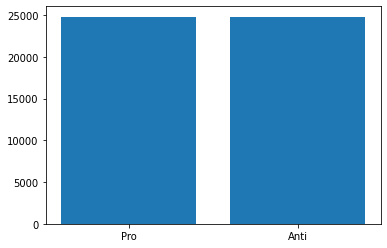

In [ ]:
import matplotlib.pyplot as plt

plt.bar(['Pro','Anti'], W)

In [ ]:
df_clean_sample.to_csv('/content/gdrive/MyDrive/SNLP project/data/preprocessed_tweets/df_clean_sampled_binary.csv', index=False)

In [ ]:
df_clean.to_csv('/content/gdrive/MyDrive/SNLP project/data/preprocessed_tweets/df_clean.csv', index=False)